<a href="https://colab.research.google.com/github/Ridhiman27/DeepVision-Hub/blob/main/Variational_Autoencoders_MNIST_Digit_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2D, Add, Conv2DTranspose, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam

In [ ]:
(x_train, _), (x_test,_) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype("float32")/255
print(mnist_digits.shape)

11490434/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 2
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration=False)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

**Model:**

**Sampling**

In [ ]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

**Encoder**

In [ ]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32,3,activation = 'relu',strides=2,padding = 'same')(encoder_inputs)
x = Conv2D(64,3,activation = 'relu',strides=2,padding = 'same')(x)
# x = BatchNormalization()

x = Flatten()(x)
x = Dense(16,activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean, log_var],name = 'encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

**Decoder**

In [ ]:
latent_inputs = Input(shape=(LATENT_DIM,))
x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

**Training**

In [ ]:
OPTIMIZER = Adam(learning_rate= 1e-3)
EPOCHS = 20

In [ ]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=(1,2)))
  loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1 - tf.math.square(mean)-tf.math.exp(log_var)), axis=1))

  return loss_rec + loss_reg

**Overall VAE Model**

In [ ]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    # print('hi')
    y_pred = decoder_model(z)
    # print('hi')
    y_true = x_batch
    loss = custom_loss(y_true,y_pred,mean,log_var)
    # print('hi')
  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  # print(partial_derivatives)
  # print('hi')
  OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
  # print('hi')

  return loss

In [ ]:
def neuralearn(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))
    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [ ]:
neuralearn(EPOCHS)

Training starts for epoch number 1


Training Loss is:  tf.Tensor(182.62242, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(167.27972, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(162.99854, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(157.77356, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(156.53343, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(154.42596, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(153.99957, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(153.09639, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(152.04073, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(151.67783, shape=(), dtype=float32)
Training starts for epoch number 1

**Testing**

In [ ]:
scale = 1
n = 16

In [ ]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [ ]:
for i in range(3):
  print(vae.layers[i])

1/1 [==============================] - 0s 16ms/step


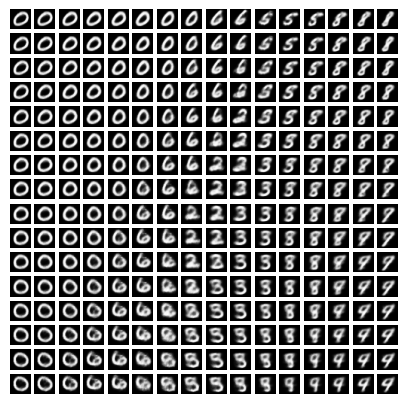

In [ ]:
plt.figure(figsize=(5,5))
k = 0
for i in grid_x:
  for j in grid_y:
    ax = plt.subplot(n,n,k+1)

    input = tf.constant([[i,j]])

    out = vae.layers[2].predict(input)[0][...,0] # using the decoder layer
    plt.imshow(out,cmap='Greys_r')
    plt.axis('off')
    k+=1


In [ ]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

1/1 [==============================] - 0s 98ms/step
(28, 28)
